# Fourier transforms
*27 Jan 2020*

This should be a simple notebook: we will just take the Fourier transform of a 2d image.

**This whole notebook needs to be updated.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from helpers import ADD
from helpers import isinmask, isinmask_smooth

Now each side is...

In [2]:
ext = .8
zl = 0.5
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print(phys_width_kpc)

9.713163759014881


## Subhalo power spectrum (numerically)

In [ ]:
!python2 make_mask.py --pix_num=196 --side=97

In [ ]:
!python2 power_spectrum.py \
--conv_file1 files/kappa_sub.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 97 \
--name subImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 power_spectrum.py \
--conv_file1 files/kappa_sub_ext0.8.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name subsmallImg \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:  
files/kappa_sub.npy  
k saved in files/ksubImg_095_196_97.txt  
saved files/ind_curves_subImg_095_196_97

Text(0.5, 1.0, 'Subhalo-only power spectrum')

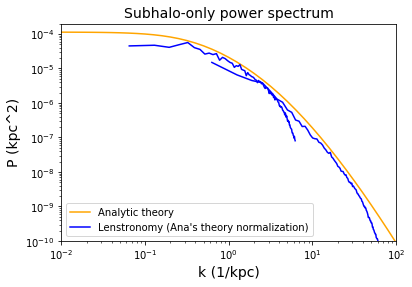

In [9]:
klist_sub = np.loadtxt('files/oldcurves/ksubImg_095_196_97.txt')
plist_sub = np.load('files/oldcurves/ind_curves_subImg_095_196_97.npy')[0]
klist_subsmall = np.loadtxt('files/oldcurves/ksubsmallImg_095_196_10.txt')
plist_subsmall = np.load('files/oldcurves/ind_curves_subsmallImg_095_196_10.npy')[0]

ana_power_58 = np.array([[0.01, 0.000121064], [0.0125893, 0.000120882], [0.0158489, 
  0.000120614], [0.0199526, 0.000120224], [0.0251189, 
  0.000119661], [0.0316228, 0.000118854], [0.0398107, 
  0.00011771], [0.0501187, 0.00011611], [0.0630957, 
  0.000113904], [0.0794328, 0.000110919], [0.1, 
  0.000106968], [0.125893, 0.000101873], [0.158489, 
  0.0000955008], [0.199526, 0.0000878155], [0.251189, 
  0.0000789222], [0.316228, 0.0000690958], [0.398107, 
  0.0000587699], [0.501187, 0.0000484742], [0.630957, 
  0.0000387358], [0.794328, 0.0000299813], [1., 
  0.0000224772], [1.25893, 0.0000163215], [1.58489, 
  0.000011475], [1.99526, 7.80641e-6], [2.51189, 
  5.135e-6], [3.16228, 3.26397e-6], [3.98107, 
  2.00407e-6], [5.01187, 1.18868e-6], [6.30957, 
  6.81452e-7], [7.94328, 3.7796e-7], [10., 
  2.03083e-7], [12.5893, 1.05869e-7], [15.8489, 
  5.36262e-8], [19.9526, 2.6429e-8], [25.1189, 
  1.26873e-8], [31.6228, 5.93833e-9], [39.8107, 
  2.71258e-9], [50.1187, 1.21067e-9], [63.0957, 
  5.28754e-10], [79.4328, 2.2643e-10], [100., 
  9.53077e-11], [125.893, 3.95397e-11], [158.489, 
  1.62138e-11], [199.526, 6.58945e-12], [251.189, 
  2.66042e-12], [316.228, 1.06909e-12], [398.107, 
  4.28235e-13], [501.187, 1.71163e-13], [630.957, 
  6.83155e-14], [794.328, 2.72413e-14], [1000., 1.08562e-14]]) # theory normalization

plt.loglog(ana_power_58[:,0], ana_power_58[:,1] * (3/3.11)**2, label='Analytic theory', color='orange')
plt.loglog(klist_sub, np.array(plist_sub)*1.906e6/1.902e5, label='Lenstronomy (Ana\'s theory normalization)', color='blue')
plt.loglog(klist_subsmall, np.array(plist_subsmall)*1.906e6/1.902e5, color='blue')
plt.legend()
plt.ylim(1e-10, 2e-4)
plt.xlim(1e-2,1e2)
plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('P (kpc^2)', size=14)
plt.title('Subhalo-only power spectrum', size=14)
#plt.savefig('imgs/mar6_subpower_numeric_analytic.png')

### Try mask for subhalos (sanity check)

In [3]:
# Define masks we'll be using
mymask = np.zeros((196,196))
for xpix in range(196):
    for ypix in range(196):
        mymask[xpix, ypix] = 1 if isinmask(xpix, ypix, 7, 1, 16/196, 196) else 0
mask_smooth = np.zeros((196,196))
for xpix in range(196):
    for ypix in range(196):
        mask_smooth[xpix, ypix] = isinmask_smooth(xpix, ypix, 7, .3, 16/196, 196)

In [4]:
mask_coverage = np.sum(mymask) / (196**2)
print('mask_coverage', mask_coverage)
mask_coverage_smooth = np.sum(mymask * mask_smooth) / (196**2)
print('mask_coverage_smooth', mask_coverage_smooth)

mask_coverage 0.3428259058725531
mask_coverage_smooth 0.12908202880885875


In [5]:
kappa_sub_large = np.load('files/oldcurves/kappa_sub.npy') # ext 8
kappa_sub_small = np.load('files/oldcurves/kappa_sub_ext0.8.npy')

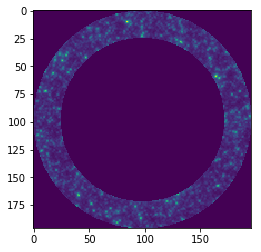

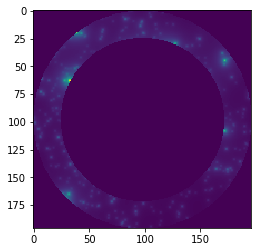

In [6]:
plt.imshow(kappa_sub_large * mymask)
plt.show()
plt.imshow(kappa_sub_small * mymask)

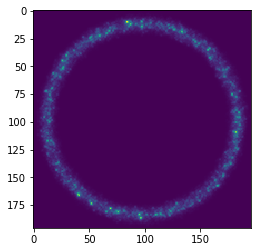

In [7]:
plt.imshow(kappa_sub_large * mymask * mask_smooth)

In [50]:
np.save('files/oldcurves/kappa_masked_sub_ext8.npy', kappa_sub_large * mymask)
np.save('files/oldcurves/kappa_masked_sub_ext0.8.npy', kappa_sub_small * mymask)
np.save('files/oldcurves/kappa_maskedsmooth_sub_ext8.npy', kappa_sub_large * mymask * mask_smooth)
np.save('files/oldcurves/kappa_maskedsmooth_sub_ext0.8.npy', kappa_sub_small * mymask * mask_smooth)

In [ ]:
!python2 make_mask.py --pix_num=196 --side=97

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_masked_sub_ext8.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 97 \
--name submaskImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_maskedsmooth_sub_ext8.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 97 \
--name submasksmoothImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 make_mask.py --pix_num=196 --side=10

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_masked_sub_ext0.8.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 10 \
--name subsmallmaskImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_maskedsmooth_sub_ext0.8.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 10 \
--name subsmallmasksmoothImg \
--num_proj 1 \
--sigma_crit 3.11e9

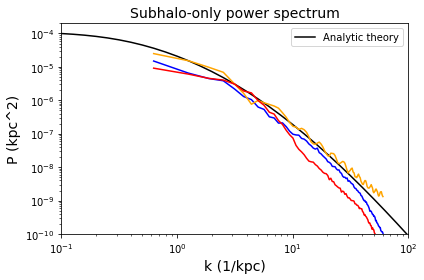

In [24]:
klist_sub_masked = np.loadtxt('files/oldcurves/ksubmaskImg_095_196_97.txt')
plist_sub_masked = np.load('files/oldcurves/ind_curves_submaskImg_095_196_97.npy')[0]
klist_subsmall_masked = np.loadtxt('files/oldcurves/ksubsmallmaskImg_095_196_10.txt')
plist_subsmall_masked = np.load('files/oldcurves/ind_curves_subsmallmaskImg_095_196_10.npy')[0]
klist_sub_maskedsmooth = np.loadtxt('files/oldcurves/ksubmasksmoothImg_095_196_97.txt')
plist_sub_maskedsmooth = np.load('files/oldcurves/ind_curves_submasksmoothImg_095_196_97.npy')[0]
klist_subsmall_maskedsmooth = np.loadtxt('files/oldcurves/ksubsmallmasksmoothImg_095_196_10.txt')
plist_subsmall_maskedsmooth = np.load('files/oldcurves/ind_curves_subsmallmasksmoothImg_095_196_10.npy')[0]

plt.loglog(ana_power_58[:,0], ana_power_58[:,1] * (3/3.11)**2, label='Analytic theory', color='k')
#plt.loglog(klist_sub, np.array(plist_sub)*1.906e6/1.902e5, label='Lenstronomy (Ana\'s theory normalization, no mask)', color='blue')
plt.loglog(klist_subsmall, np.array(plist_subsmall)*1.906e6/1.902e5, color='blue')
#plt.loglog(klist_sub_masked, np.array(plist_sub_masked)*1.906e6/1.902e5 / mask_coverage, label='Lenstronomy (Ana\'s theory normalization, sharp mask)', color='orange')
plt.loglog(klist_subsmall_masked, np.array(plist_subsmall_masked)*1.906e6/1.902e5 / mask_coverage, color='orange')
#plt.loglog(klist_sub_maskedsmooth, np.array(plist_sub_maskedsmooth)*1.906e6/1.902e5 / mask_coverage_smooth, label='Lenstronomy (Ana\'s theory normalization, smooth mask)', color='red')
plt.loglog(klist_subsmall_maskedsmooth, np.array(plist_subsmall_maskedsmooth)*1.906e6/1.902e5 / mask_coverage_smooth, color='red')
plt.legend()
plt.ylim(1e-10, 2e-4)
plt.xlim(1e-1,1e2)
plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('P (kpc^2)', size=14)
plt.title('Subhalo-only power spectrum', size=14)
plt.tight_layout()
#plt.savefig('imgs/mar20_subpower2.png')

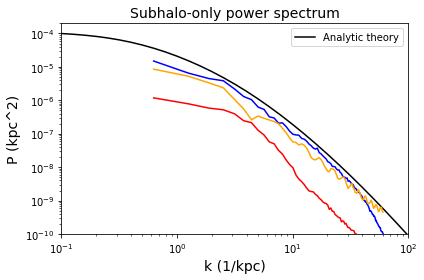

In [26]:
plt.loglog(ana_power_58[:,0], ana_power_58[:,1] * (3/3.11)**2, label='Analytic theory', color='k')
#plt.loglog(klist_sub, np.array(plist_sub)*1.906e6/1.902e5, label='Lenstronomy (Ana\'s theory normalization, no mask)', color='blue')
plt.loglog(klist_subsmall, np.array(plist_subsmall)*1.906e6/1.902e5, color='blue')
#plt.loglog(klist_sub_masked, np.array(plist_sub_masked)*1.906e6/1.902e5 / mask_coverage, label='Lenstronomy (Ana\'s theory normalization, sharp mask)', color='orange')
plt.loglog(klist_subsmall_masked, np.array(plist_subsmall_masked)*1.906e6/1.902e5 , color='orange')
#plt.loglog(klist_sub_maskedsmooth, np.array(plist_sub_maskedsmooth)*1.906e6/1.902e5 / mask_coverage_smooth, label='Lenstronomy (Ana\'s theory normalization, smooth mask)', color='red')
plt.loglog(klist_subsmall_maskedsmooth, np.array(plist_subsmall_maskedsmooth)*1.906e6/1.902e5 , color='red')
plt.legend()
plt.ylim(1e-10, 2e-4)
plt.xlim(1e-1,1e2)
plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('P (kpc^2)', size=14)
plt.title('Subhalo-only power spectrum', size=14)
plt.tight_layout()
#plt.savefig('imgs/mar20_subpower2.png')

## Same thing for interlopers
First, interlopers only, $\theta = 7$, image size $8$.

In [14]:
kappa_large = np.load('files/oldcurves/kappa_intreal_ext8_theta7.npy')
kappa_small = np.load('files/oldcurves/kappa_intreal_ext0.8_theta0.7.npy')

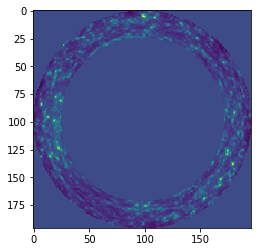

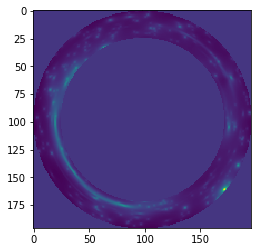

In [15]:
plt.imshow(kappa_large * mymask)
plt.show()
plt.imshow(kappa_small * mymask)

In [63]:
np.save('files/oldcurves/kappa_masked_intreal_ext8_theta7.npy', kappa_large * mymask)
np.save('files/oldcurves/kappa_masked_intreal_ext0.8_theta0.7.npy', kappa_small * mymask)
np.save('files/oldcurves/kappa_maskedsmooth_intreal_ext8_theta7.npy', kappa_large * mymask * mask_smooth)
np.save('files/oldcurves/kappa_maskedsmooth_intreal_ext0.8_theta0.7.npy', kappa_small * mymask * mask_smooth)

In [ ]:
!python2 make_mask.py --pix_num=196 --side=97

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_masked_intreal_ext8_theta7.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 97 \
--name intImg \
--num_proj 1 \
--sigma_crit 3.11e9


!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_maskedsmooth_intreal_ext8_theta7.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 97 \
--name intsmoothImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 make_mask.py --pix_num=196 --side=10

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_masked_intreal_ext0.8_theta0.7.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 10 \
--name intSmallImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 power_spectrum.py \
--conv_file1 files/oldcurves/kappa_maskedsmooth_intreal_ext0.8_theta0.7.npy \
--kdir files/oldcurves/ \
--psdir files/oldcurves/ \
--pix_num 196 \
--side 10 \
--name intSmallsmoothImg \
--num_proj 1 \
--sigma_crit 3.11e9

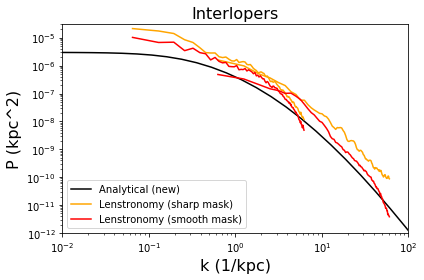

In [16]:
klist_int = np.loadtxt('files/oldcurves/kintImg_095_196_97.txt')
plist_int = np.load('files/oldcurves/ind_curves_intImg_095_196_97.npy')[0]
klist_intsmall = np.loadtxt('files/oldcurves/kintSmallImg_095_196_10.txt')
plist_intsmall = np.load('files/oldcurves/ind_curves_intSmallImg_095_196_10.npy')[0]
klist_int_smooth = np.loadtxt('files/oldcurves/kintsmoothImg_095_196_97.txt')
plist_int_smooth = np.load('files/oldcurves/ind_curves_intsmoothImg_095_196_97.npy')[0]
klist_intsmall_smooth = np.loadtxt('files/oldcurves/kintSmallsmoothImg_095_196_10.txt')
plist_intsmall_smooth = np.load('files/oldcurves/ind_curves_intSmallsmoothImg_095_196_10.npy')[0]

ps_int_oldmassratio = np.array([[1.00000000e-02, 3.72742913e-06],
       [1.48735211e-02, 3.71905991e-06],
       [2.21221629e-02, 3.70341572e-06],
       [3.29034456e-02, 3.67406165e-06],
       [4.89390092e-02, 3.61891825e-06],
       [7.27895384e-02, 3.52395138e-06],
       [1.08263673e-01, 3.36510847e-06],
       [1.61026203e-01, 3.11569490e-06],
       [2.39502662e-01, 2.76311717e-06],
       [3.56224789e-01, 2.30443172e-06],
       [5.29831691e-01, 1.79813973e-06],
       [7.88046282e-01, 1.29550830e-06],
       [1.17210230e+00, 8.49782028e-07],
       [1.74332882e+00, 5.20307686e-07],
       [2.59294380e+00, 2.92227173e-07],
       [3.85662042e+00, 1.47246395e-07],
       [5.73615251e+00, 6.95208322e-08],
       [8.53167852e+00, 3.04386208e-08],
       [1.26896100e+01, 1.19314997e-08],
       [1.88739182e+01, 4.40402177e-09],
       [2.80721620e+01, 1.53079938e-09],
       [4.17531894e+01, 4.83655782e-10],
       [6.21016942e+01, 1.45347376e-10],
       [9.23670857e+01, 4.12648579e-11],
       [1.37382380e+02, 1.11142553e-11],
       [2.04335972e+02, 2.76737360e-12],
       [3.03919538e+02, 6.65384954e-13],
       [4.52035366e+02, 1.59007238e-13],
       [6.72335754e+02, 3.39680077e-14],
       [1.00000000e+03, 7.24650826e-15]])

ps_new = np.array([[1.00000000e-02, 2.96144235e-06],
       [1.48735211e-02, 2.94469871e-06],
       [2.21221629e-02, 2.91395330e-06],
       [3.29034456e-02, 2.85930822e-06],
       [4.89390092e-02, 2.76615969e-06],
       [7.27895384e-02, 2.61569135e-06],
       [1.08263673e-01, 2.38901591e-06],
       [1.61026203e-01, 2.07642308e-06],
       [2.39502662e-01, 1.69006224e-06],
       [3.56224789e-01, 1.27016491e-06],
       [5.29831691e-01, 8.73670052e-07],
       [7.88046282e-01, 5.48296053e-07],
       [1.17210230e+00, 3.13702851e-07],
       [1.74332882e+00, 1.63351095e-07],
       [2.59294380e+00, 7.71767288e-08],
       [3.85662042e+00, 3.30090163e-08],
       [5.73615251e+00, 1.27936223e-08],
       [8.53167852e+00, 4.51098569e-09],
       [1.26896100e+01, 1.45616440e-09],
       [1.88739182e+01, 4.33203892e-10],
       [2.80721620e+01, 1.19334985e-10],
       [4.17531894e+01, 3.05823425e-11],
       [6.21016942e+01, 7.33894951e-12],
       [9.23670857e+01, 1.66497317e-12],
       [1.37382380e+02, 3.62086669e-13],
       [2.04335972e+02, 7.65657039e-14],
       [3.03919538e+02, 1.59205583e-14],
       [4.52035366e+02, 3.27928426e-15],
       [6.72335754e+02, 6.72623732e-16],
       [1.00000000e+03, 1.37752342e-16]])

plt.loglog(ps_new[:,0], ps_new[:,1], label='Analytical (new)', color='k')
plt.loglog(klist_int, plist_int/mask_coverage, label='Lenstronomy (sharp mask)', color='orange') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall, plist_intsmall/mask_coverage, color='orange') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_int_smooth, plist_int_smooth/mask_coverage_smooth, label='Lenstronomy (smooth mask)', color='red') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall_smooth, plist_intsmall_smooth/mask_coverage_smooth, color='red') # 0.129 for smooth mask, 0.343 for sharp mask

plt.legend()
plt.xlabel('k (1/kpc)', size=16)
plt.ylabel('P (kpc^2)', size=16)
plt.title('Interlopers', size=16)
plt.ylim(1e-12, 3e-5)
plt.xlim(1e-2,1e2)
plt.tight_layout()
#plt.savefig('imgs/mar20_intpower.png')

In [24]:
np.save('files/for_cagan/int.npy', np.vstack([klist_int, plist_int]).T)
np.save('files/for_cagan/intsmall.npy',np.vstack([klist_intsmall, plist_intsmall]).T)
np.save('files/for_cagan/int_smooth.npy',np.vstack([klist_int_smooth, plist_int_smooth]).T)
np.save('files/for_cagan/intsmall_smooth.npy',np.vstack([klist_intsmall_smooth, plist_intsmall_smooth]).T)

In [2]:
2.1e-5/2.96e-6

7.094594594594594

In [10]:
h = .675

In [2]:
plt.loglog(ps_new[:,0], ps_new[:,1] / h**3, label='Analytical (new) / h^3', color='k')
plt.loglog(klist_int, plist_int/mask_coverage, label='Lenstronomy (16 x 16 ", sharp mask)', color='orange') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall, plist_intsmall/mask_coverage, color='orange') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_int_smooth, plist_int_smooth/mask_coverage_smooth, label='Lenstronomy (16 x 16 ", smooth mask)', color='red') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall_smooth, plist_intsmall_smooth/mask_coverage_smooth, color='red') # 0.129 for smooth mask, 0.343 for sharp mask

plt.legend()
plt.xlabel('k (1/kpc)', size=16)
plt.ylabel('P (kpc^2)', size=16)
plt.title('Interlopers', size=16)
plt.ylim(1e-12, 3e-5)
plt.xlim(1e-2,1e2)
plt.tight_layout()
#plt.savefig('imgs/mar20_intpower2.png')

NameError: name 'plt' is not defined

In [ ]:
!python2 make_mask.py --pix_num=196 --side=97

!python2 power_spectrum.py \
--conv_file1 files/kappa_intreal_ext8_theta7.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 97 \
--name intnomaskImg \
--num_proj 1 \
--sigma_crit 3.11e9

!python2 make_mask.py --pix_num=196 --side=10

!python2 power_spectrum.py \
--conv_file1 files/kappa_intreal_ext0.8_theta0.7.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name intSmallnomaskImg \
--num_proj 1 \
--sigma_crit 3.11e9

In [91]:
klist_int_nomask = np.loadtxt('files/kintnomaskImg_095_196_97.txt')
plist_int_nomask = np.load('files/ind_curves_intnomaskImg_095_196_97.npy')[0]
klist_intsmall_nomask = np.loadtxt('files/kintSmallnomaskImg_095_196_10.txt')
plist_intsmall_nomask = np.load('files/ind_curves_intSmallnomaskImg_095_196_10.npy')[0]

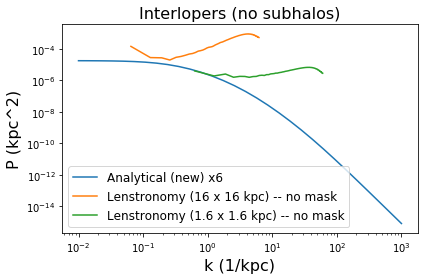

In [99]:
plt.loglog(ps_new[:,0], ps_new[:,1] * 6, label='Analytical (new) x6')
plt.loglog(klist_int_nomask, plist_int_nomask, label='Lenstronomy (16 x 16 kpc) -- no mask') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall_nomask, plist_intsmall_nomask, label='Lenstronomy (1.6 x 1.6 kpc) -- no mask') # 0.129 for smooth mask, 0.343 for sharp mask
#plt.loglog(ps_int_oldmassratio[:,0], ps_int_oldmassratio[:,1], label='Analytical (old, wrong)')
plt.legend(fontsize=12)
plt.xlabel('k (1/kpc)', size=16)
plt.ylabel('P (kpc^2)', size=16)
plt.title('Interlopers (no subhalos)', size=16)
# plt.ylim(1e-12, 3e-5)
# plt.xlim(1e-2,1e2)
plt.tight_layout()

---
Old cells below

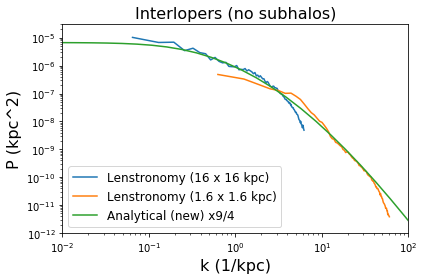

In [19]:
plt.loglog(klist_int, plist_int/mask_coverage, label='Lenstronomy (16 x 16 kpc)') # 0.129 for smooth mask, 0.343 for sharp mask
plt.loglog(klist_intsmall, plist_intsmall/mask_coverage, label='Lenstronomy (1.6 x 1.6 kpc)') # 0.129 for smooth mask, 0.343 for sharp mask
#plt.loglog(ps_int_oldmassratio[:,0], ps_int_oldmassratio[:,1], label='Analytical (old, wrong)')
#plt.loglog(ps_new[:,0], ps_new[:,1], label='Analytical (new)')
plt.loglog(ps_new[:,0], ps_new[:,1]*9/4, label='Analytical (new) x9/4')
plt.legend(fontsize=12)
plt.xlabel('k (1/kpc)', size=16)
plt.ylabel('P (kpc^2)', size=16)
plt.title('Interlopers (no subhalos)', size=16)
plt.ylim(1e-12, 3e-5)
plt.xlim(1e-2,1e2)
plt.tight_layout()
#plt.savefig('imgs/mar18_intpower2.png')

In [ ]:
# TODO: plot side-by-side with power spectrum from smaller kappa_sub

In [ ]:
!python2 power_spectrum.py \
--conv_file1 files/kappa_intnaive.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 97 \
--name intnaiveImg \
--num_proj 1 \
--sigma_crit 3.11e9

In [37]:
klist_intnaive = np.loadtxt('files/kintnaiveImg_095_196_97.txt')
plist_intnaive = np.load('files/ind_curves_intnaiveImg_095_196_97.npy')[0]

I see: we may have forgotten to subtract out the main lens...

In [ ]:
!python2 power_spectrum.py \
--conv_file1 files/kappa_full_smooth.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 97 \
--name fullImg \
--num_proj 1 \
--sigma_crit 3.11e9

In [64]:
klist_full = np.loadtxt('files/kfullImg_095_196_97.txt')
plist_full = np.load('files/ind_curves_fullImg_095_196_97.npy')[0]

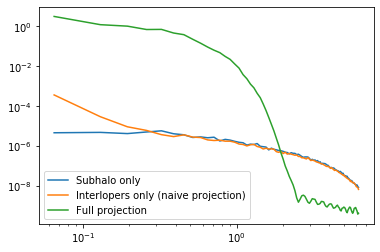

In [65]:
plt.loglog(klist_sub, plist_sub, label='Subhalo only')
plt.loglog(klist_intnaive, plist_intnaive, label='Interlopers only (naive projection)')
plt.loglog(klist_full, plist_full, label='Full projection')
plt.legend()

Whatever is above seems very wrong...

## Sanity check

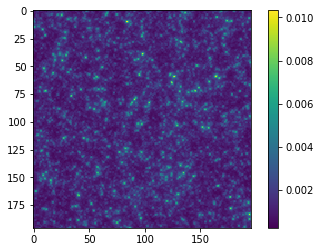

In [42]:
kappa_sub = np.load('files/kappa_sub.npy')
plt.imshow(kappa_sub)
plt.colorbar()

In [60]:
kappa_intnaive = np.load('files/kappa_intnaive.npy')
plt.imshow(kappa_intnaive)
plt.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: 'files/kappa_intnaive.npy'

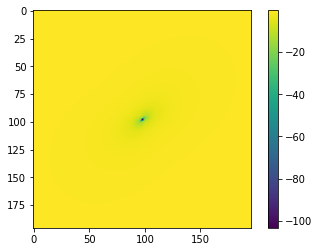

In [46]:
kappa_full = np.load('files/kappa_full_ext8_theta7.npy')
plt.imshow(kappa_full)
plt.colorbar()
## Forgot to take the mask blank image!!! ###

In [49]:
for xpix in range(196):
    for ypix in range(196):
        if not isinmask(xpix, ypix, 7, 1.1, 16/196., 196):
            kappa_full[xpix, ypix] = 0

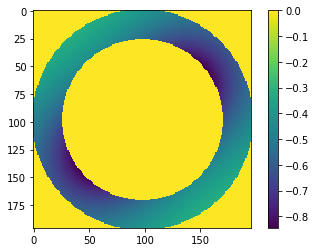

In [50]:
plt.imshow(kappa_full)
plt.colorbar()

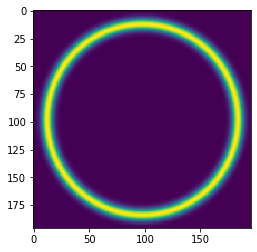

In [52]:
mask_smooth = np.zeros((196, 196))
for xpix in range(196):
    for ypix in range(196):
        mask_smooth[xpix, ypix] = isinmask_smooth(xpix, ypix, 7, .3, 16/196., 196)
plt.imshow(mask_smooth)

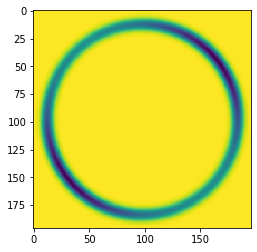

In [61]:
plt.imshow(mask_smooth * kappa_full)

In [62]:
kappa_full_smooth = mask_smooth * kappa_full

In [63]:
np.save('files/kappa_full_smooth.npy', kappa_full_smooth)

In [47]:
kappa_intreal = np.load('files/kappa_intreal.npy')

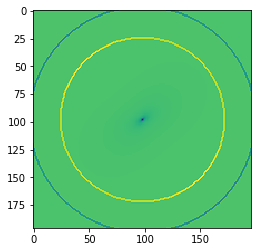

In [48]:
plt.imshow(kappa_intreal)

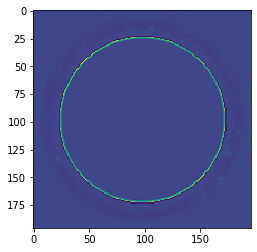

In [54]:
plt.imshow(kappa_intreal * mask_smooth)

# Old notebook below

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import fftpack

Now we still need an image...

In [3]:
from helpers import CustomImage

In [4]:
# Simple image:
zl = 0.2
xs = [0,2]
ys = [10,-2]
redshifts = [.2,.25]

In [5]:
# Now we'll try something more intense
np.random.seed(123)

zl = 0.2
xs, ys, redshifts = [], [], []
for i in range(20):
    xs.append( np.random.uniform(-15,15) )
    ys.append( np.random.uniform(-15,15) )
    redshifts.append( np.random.uniform(0,1) ) 

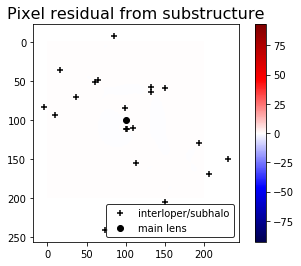

In [6]:
blankimg = CustomImage([],[],[], zl=zl)

myimg = CustomImage(xs, ys, redshifts, zl=zl, m=1e7)

vmin = np.min(myimg.image - blankimg.image)
vmax = np.max(myimg.image - blankimg.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg.image - blankimg.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg.x_to_pix(0)], [myimg.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

plt.show()

In [7]:
divmat, curlmat = myimg.calc_div_curl()

In [8]:
divmat_blank, curlmat_blank = blankimg.calc_div_curl()

The image is:

In [9]:
#image = divmat

In [10]:
image = (divmat - divmat_blank).T

In [11]:
def autoshow(image, vmax=None):
    if vmax == None:
        vmin = np.min(image)
        vmax = np.max(image)
        vmin = min(vmin, -vmax)
        vmax = max(vmax, -vmin)
    else:
        vmin = -vmax

    ext=20
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='seismic', extent=[-ext,ext,ext,-ext])
    plt.colorbar()
    #plt.show()

Text(0.5, 1.0, '$\\kappa_\\mathrm{eff}$')

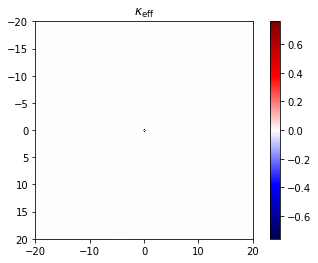

In [12]:
autoshow(image)#, vmax=.003)
plt.title(r'$\kappa_\mathrm{eff}$')
#plt.savefig('imgs/jan27_full.png')

In [13]:
#sorted(abs(inner_image.flatten()), reverse=True)

In [14]:
npix = 2

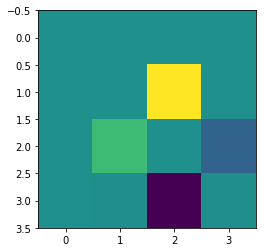

In [15]:
plt.imshow(image[100-npix:100+npix,100-npix:100+npix])

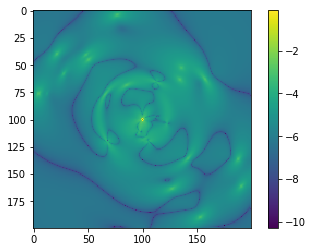

In [16]:
plt.imshow(np.log10(abs(image)))
plt.colorbar()

Text(0.5, 1.0, '$\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

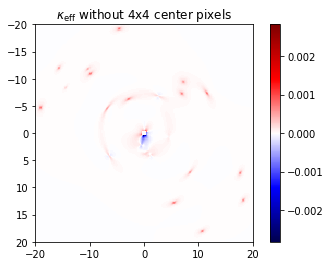

In [17]:
outer_image = np.copy(image)
for i in range(100-npix,100+npix):
    for j in range(100-npix,100+npix):
        outer_image[i,j] = 0

autoshow(outer_image)
plt.title(r'$\kappa_\mathrm{eff}$ without 4x4 center pixels')
#plt.savefig('imgs/jan27_outer.png')

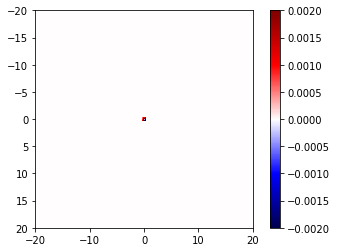

In [18]:
inner_image = np.zeros((200,200))
for i in range(100-npix,100+npix):
    for j in range(100-npix,100+npix):
        inner_image[i,j] = image[i,j]

autoshow(inner_image, vmax=.002)

## Tutorial
Hey look at [this link](https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/)! It's perfect!

Text(0.5, 1.0, 'fft: $\\kappa_\\mathrm{eff}$')

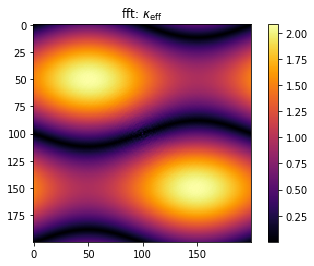

In [385]:
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift(F1)
plt.imshow(abs(F2), cmap='inferno')
plt.colorbar()
plt.title(r'fft: $\kappa_\mathrm{eff}$')
#plt.savefig('imgs/jan27_fft_full.png')

In [ ]:
F1 = fftpack.fft2(inner_image)
F2 = fftpack.fftshift(F1)
plt.imshow(np.abs(F2), cmap='inferno')
plt.colorbar()

Text(0.5, 1.0, 'fft: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

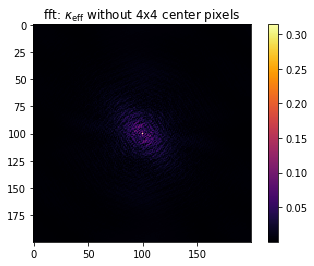

In [389]:
F1 = fftpack.fft2(outer_image)
F2 = fftpack.fftshift(F1)
plt.imshow(abs(F2), cmap='inferno')
plt.colorbar()
plt.title(r'fft: $\kappa_\mathrm{eff}$ without 4x4 center pixels')
#plt.savefig('imgs/jan27_fft_outer.png')

Text(0.5, 1.0, 'log10 fft: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

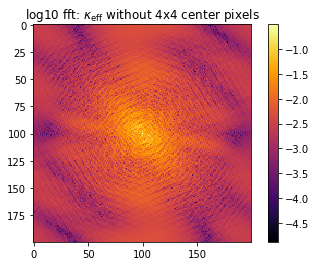

In [390]:
plt.imshow(np.log10(abs(F2)), cmap='inferno')
plt.colorbar()
plt.title('log10 fft: $\kappa_\mathrm{eff}$ without 4x4 center pixels')

Text(0.5, 1.0, 'fft angle: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

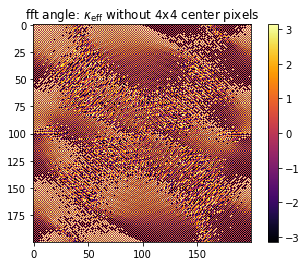

In [391]:
plt.imshow(np.angle(F2), cmap='inferno')
plt.colorbar()
plt.title('fft angle: $\kappa_\mathrm{eff}$ without 4x4 center pixels')

In [392]:
ps2d = np.abs(F2)**2

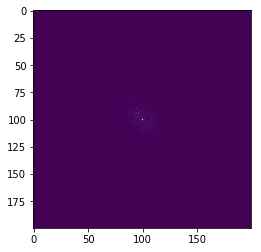

In [393]:
plt.imshow(ps2d)

In [394]:
def azimuthalAverage(image, center=None):
    """
    (from https://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles)
    
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

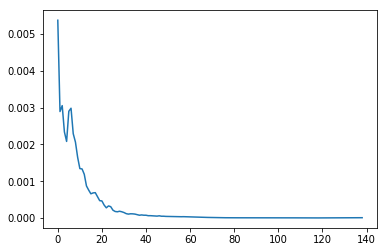

In [395]:
plt.plot(azimuthalAverage(ps2d))
#plt.savefig('imgs/jan27_ps_2int.png')

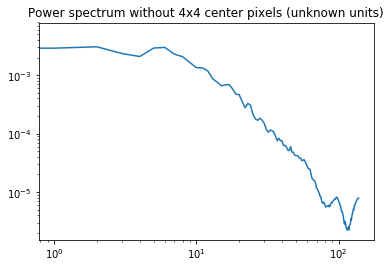

In [399]:
plt.loglog(azimuthalAverage(ps2d))
plt.title('Power spectrum without 4x4 center pixels (unknown units)')
plt.savefig('imgs/jan27_outer_ps.png')

Hmm, but how do we compare this with our actual units?

More basic stuff:

In [188]:
from numpy.fft import fft

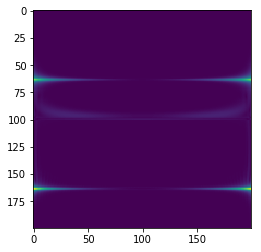

In [189]:
plt.imshow(abs(fft(image)))

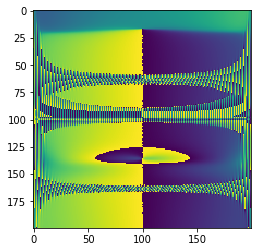

In [190]:
plt.imshow(np.angle(fft(image)))

In [168]:
from numpy.fft import fftshift

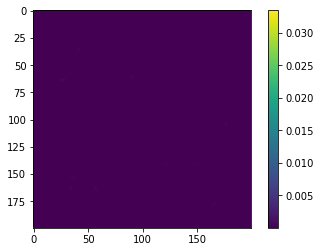

In [169]:
plt.imshow(abs(fftshift(image)));
plt.colorbar()
plt.show()

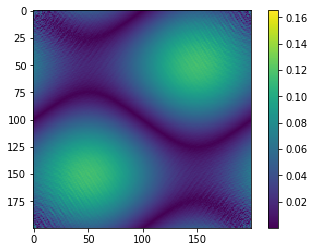

In [170]:
plt.imshow(abs(fft2(image)));
plt.colorbar()
plt.show()

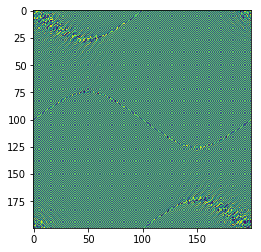

In [171]:
plt.imshow(np.angle(fft2(image)))

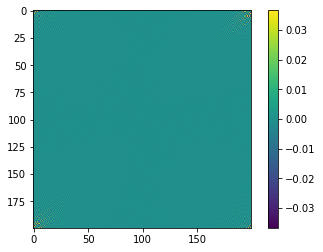

In [35]:
plt.imshow(np.imag(fft2(image))); plt.colorbar()

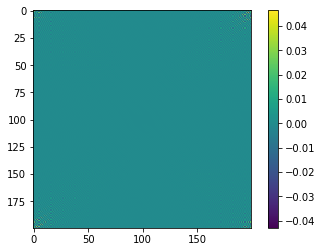

In [37]:
plt.imshow(np.real(fft2(image))); plt.colorbar()

## Using Ana's code

In [19]:
np.save('files/outer_image.npy', outer_image)

In [27]:
!python2 --version

Python 2.7.13


In [28]:
myimg.pixnum * myimg.pixsize # arcsec

40.0

In [31]:
# Calculate physical size of the image
distance = 845000 # kpc
angle = 40 * np.pi/648000 # rad

In [32]:
angle * distance # kpc

163.86702421502315

In [44]:
myimg.pixnum

200

In [46]:
!python2 make_mask.py --pix_num=200 --side=164

In [42]:
!python2 power_spectrum.py \
--conv_file1 files/convmat_residuals_theta1.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name testDM \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_residuals_theta1.npy
k saved in files/ktestDM_095_196_10.txt
saved files/ind_curves_testDM_095_196_10


In [4]:
klist = np.loadtxt('files/ktestDM_095_196_10.txt')
plist = np.load('files/ind_curves_testDM_095_196_10.npy')

In [5]:
len(plist[0])

96

In [6]:
len(klist)

96

Text(0, 0.5, 'Power (kpc^2)')

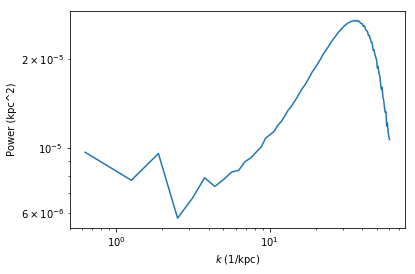

In [7]:
plt.loglog(klist, plist[0])
plt.xlabel(r'$k$ (1/kpc)')
plt.ylabel(r'Power (kpc^2)')

## Annulus mask

In [8]:
convmat = np.load('files/convmat_residuals_theta1.npy')

In [10]:
from helpers import autoshow

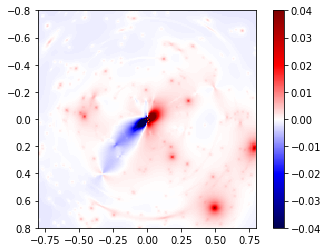

In [33]:
autoshow(convmat, vmax=.04, ext=.8)

In [25]:
def isinmask(xpix, ypix, r, dr, pixsize, pixnum):
    # r is the einstein radius, and we take pixels within r +- dr
    npix = np.sqrt((xpix-pixnum/2)**2 + (ypix-pixnum/2)**2)
    pixdist = npix * pixsize
    #print('npix', npix, 'pixdist', pixdist, 'r-dr', r-dr, 'r+dr', r+dr)
    return (r - dr < pixdist < r + dr)

In [35]:
mask = np.zeros((196,196))
for i in range(196):
    for j in range(196):
        mask[i,j] = isinmask(i,j, 0.7, 0.05, .008, 196)

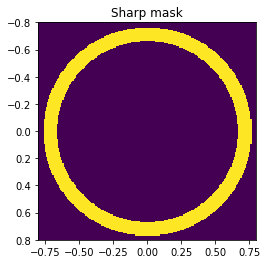

In [74]:
ext = 0.8
plt.imshow(mask, extent=[-ext,ext,ext,-ext])
plt.title('Sharp mask')
#plt.savefig('imgs/feb13_sharp_mask.png')

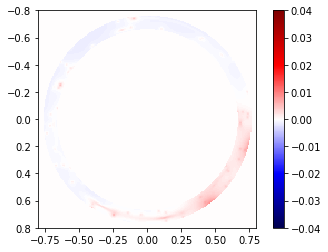

In [59]:
masked_convmat = mask * convmat
autoshow(masked_convmat, ext=.8, vmax=0.04)

In [39]:
np.save('files/masked_convmat_test.npy', masked_convmat)

In [57]:
def isinmask_smooth(xpix, ypix, r, dr, pixsize, pixnum):
    # r is the einstein radius, and we take pixels within r +- dr
    npix = np.sqrt((xpix-pixnum/2)**2 + (ypix-pixnum/2)**2)
    pixdist = npix * pixsize
    #print('npix', npix, 'pixdist', pixdist, 'r-dr', r-dr, 'r+dr', r+dr)
    return np.exp(-(pixdist-r)**2/(2*dr**2))

In [73]:
mask_smooth = np.zeros((196,196))
for i in range(196):
    for j in range(196):
        mask_smooth[i,j] = isinmask_smooth(i,j, 0.7, 0.05, .008, 196)

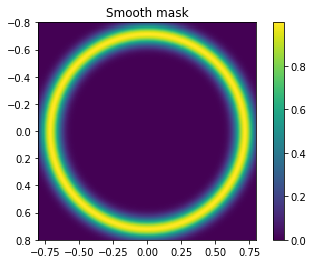

In [75]:
ext = 0.8
plt.imshow(mask_smooth, extent=[-ext,ext,ext,-ext])
plt.colorbar()
plt.title('Smooth mask')
#plt.savefig('imgs/feb13_smooth_mask.png')

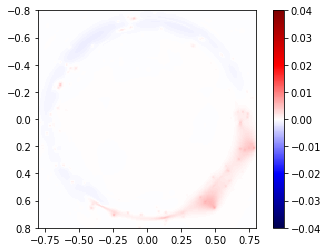

In [60]:
masked_convmat_smooth = mask_smooth * convmat
autoshow(masked_convmat_smooth, ext=.8, vmax=0.04)

In [61]:
#np.save('files/masked_convmat_smooth_test.npy', masked_convmat_smooth)

In [ ]:
!python2 make_mask.py --pix_num=196 --side=10

In [41]:
!python2 power_spectrum.py \
--conv_file1 files/masked_convmat_test.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name maskTest \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/masked_convmat_test.npy
k saved in files/kmaskTest_095_196_10.txt
saved files/ind_curves_maskTest_095_196_10


In [43]:
klist_mask = np.loadtxt('files/kmaskTest_095_196_10.txt')
plist_mask = np.load('files/ind_curves_maskTest_095_196_10.npy')

In [62]:
!python2 power_spectrum.py \
--conv_file1 files/masked_convmat_smooth_test.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name maskSmoothTest \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/masked_convmat_smooth_test.npy
k saved in files/kmaskSmoothTest_095_196_10.txt
saved files/ind_curves_maskSmoothTest_095_196_10


In [63]:
klist_mask_smooth = np.loadtxt('files/kmaskSmoothTest_095_196_10.txt')
plist_mask_smooth = np.load('files/ind_curves_maskSmoothTest_095_196_10.npy')

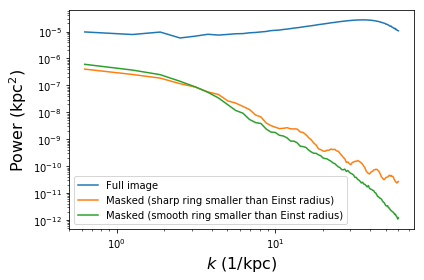

In [66]:
plt.loglog(klist, plist[0], label='Full image')
plt.loglog(klist_mask, plist_mask[0], label='Masked (sharp ring smaller than Einst radius)')
plt.loglog(klist_mask_smooth, plist_mask_smooth[0], label='Masked (smooth ring smaller than Einst radius)')
plt.legend()
plt.xlabel(r'$k$ (1/kpc)', size=16)
plt.ylabel(r'Power (kpc$^2$)', size=16)
plt.tight_layout()
#plt.savefig('imgs/feb13_mask_test.png')